In [1]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cvxpy as cp
import numpy as np

In [3]:
def sp_noise(image):
    row,col = image.shape
    s_vs_p = 0.5
    amount = 0.05
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

In [4]:
#Quadratic Filter
def quadratic_filter(im, lamb=1):
    '''Quadratic Filter.

    Args:
        im (np.ndarray): The noisy image to be filtered.
        lamb (float): The free parameter (lambda) that determines how much to correct.

    Returns:
        clean_im (np.ndarray): The filtered image.
    '''

    X = cp.Variable(im.shape)
    dXdx = cp.diff(X, k=1, axis=0)
    dXdy = cp.diff(X, k=1, axis=1)
    objective = cp.Minimize(cp.sum_squares(X - im) + lamb * cp.sum_squares(dXdx) + lamb * cp.sum_squares(dXdy))

    prob = cp.Problem(objective)
    try:
        prob.solve(verbose=True)
    except cp.SolverError as e:
        print('[ERROR] Quadratic Filter Failed.')
        print(e)
        exit()
    clean_im = X.value
    return clean_im

In [5]:
'''Total Variation (L1) Filter'''
def TV_filter_pd(im, lamb=1, niter=100):
    '''Total Variation (L1) Filter coded using the primal dual algorithm.

    Args:
        im (np.ndarray): The noisy image to be filtered.
        lamb (float): The free parameter (lambda) that determines how much to correct.
        niter (int): The number of iterations to run.

    Returns:
        clean_im (np.ndarray): The filtered image.
    '''
    tau = 0.02
    sigma = 1.0 / (8.0 * tau)
    lt = lamb * tau
    n = im.shape[0]

    clean_im = im
    shift = list(range(1, n)) + [n - 1]

    p = np.zeros((n, n, 2))
    p[:, :, 0] = clean_im[:, shift] - clean_im
    p[:, :, 1] = clean_im[shift, :] - clean_im

    for _ in range(niter):
        ux = clean_im[:, shift] - clean_im
        uy = clean_im[shift, :] - clean_im
        p = p + sigma * np.dstack([ux, uy])

        normep = np.maximum(1, np.sqrt(np.square(p[:, :, 0]) + np.square(p[:, :, 1])))
        p[:, :, 0] = p[:, :, 0] / normep
        p[:, :, 1] = p[:, :, 1] / normep

        div = np.vstack((p[0:n - 1, :, 1], np.zeros((1, n)))) - np.vstack((np.zeros((1, n)), p[0:n - 1, :, 1]))
        div = np.hstack((p[:, 0:n - 1, 0], np.zeros((n, 1)))) - np.hstack((np.zeros((n, 1)), p[:, 0:n - 1, 0])) + div

        clean_im = (clean_im + tau * div + lt * im) / (1 + tau)
    return clean_im

In [6]:
'''A collection of utility functions. '''

import os
from math import log10, sqrt

import numpy as np
from PIL import Image


def read_image(filename):
    '''Reads one of the images, resizes them, and normalizes them to have pixels between 0 and 1.

    Args:
        filename (str): The name of the image to be read (e.g. clock).

    Returns:
        im (np.ndarray): The normalized, resized image.
    '''
    im = Image.open(f'./images/{filename}.png')
    im = im.resize((256, 256))
    im = np.array(im)
    im = normalize_image(im)
    return im


def add_gaussian_noise(im, mean=0, var=0.01):
    '''Adds Gaussian noise to an image with the given variance.

    Args:
        mean (float): The mean of the Gaussian noise that is added.
        var (float): The variance of the Gaussian noise that is added.

    Returns:
        noisy_im (np.ndarray): The noisy image.
    '''
    sigma = var**0.5
    gaussian_noise = np.random.normal(mean, sigma, im.shape)
    noisy_im = im + gaussian_noise
    noisy_im = normalize_image(noisy_im)
    return noisy_im


def add_poisson_noise(im, photons=100):
    '''Adds Poisson noise to an image with the given variance.

    Args:
        photons (float): The number of photons available per pixel.

    Returns:
        noisy_im (np.ndarray): The noisy image.
    '''
    noisy_im = np.random.poisson(im * photons) / photons
    noisy_im = normalize_image(noisy_im)
    return noisy_im


def normalize_image(im):
    '''Normalizes an image to have pixels only from 0-1

    Args:
        im (np.ndarray): The image to be normalized.

    Returns:
        normalized_im (np.ndarray): The normalized image.
    '''
    max_pixel = np.max(im)
    min_pixel = np.min(im)
    normalized_im = (im - min_pixel) / max_pixel
    return normalized_im


def PSNR(original_im, cleaned_im):
    '''Calculates the Peak Signal-to-Noise Ratio (PSNR) between two images.

    Args:
        original_im (np.ndarray): The original image (without any noise).
        cleaned_im (np.ndarray): The filtered image (trying to clear the noise).

    Returns:
        psnr (float): The normalized, resized image.
    '''
    mse = np.mean((original_im - cleaned_im)**2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


def create_results_directory(noise_type, images, hyperparameters):
    '''Creates the necessary results directory structure.

    Args:
        noise_type (str): The type of noise, either 'gaussian' or 'poisson'.
        images (list): The list of image names, e.g. 'clock'.
        hyperparameters (list): The list of hyperparameters for that noise being tested.
    '''
    for image in images:
        for var in hyperparameters:
            str_var = str(var).replace('.', '_')
            os.makedirs(f'./results/{noise_type}/{image}/var_{str_var}/', exist_ok=True)


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 22 12:14:40 AM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Aug 22 12:14:40 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 22 12:14:40 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 22 12:14:40 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 22 12:14:40 AM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 22 12:14:40 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

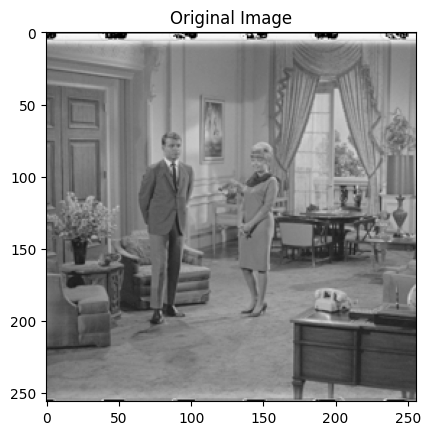

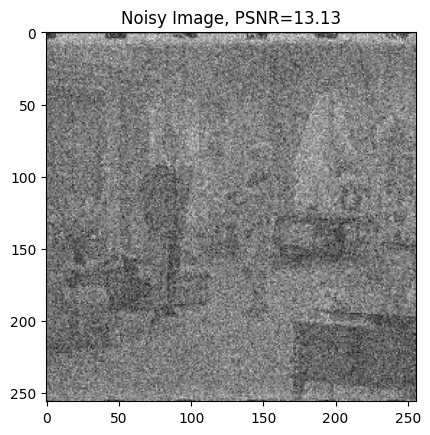

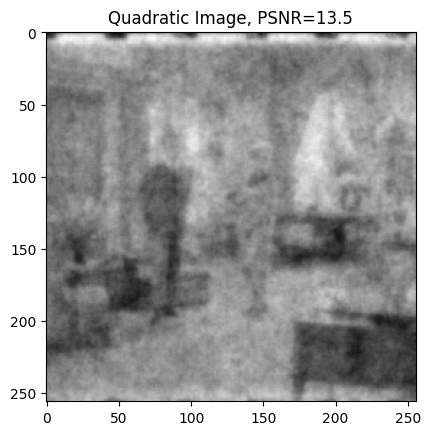

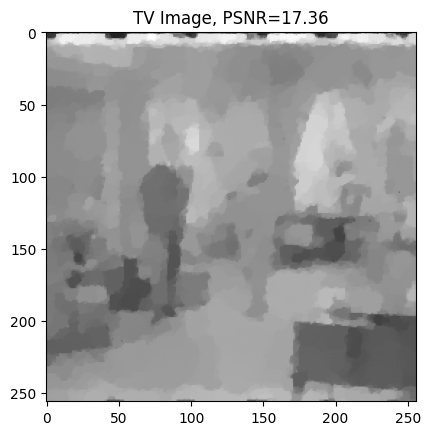

In [7]:
'''Main file for running experiments.'''

import time
import pickle

import numpy as np
import matplotlib.pyplot as plt

# from filters.quadratic_filter import quadratic_filter
# from filters.TV_filter import TV_filter
# from filters.TV_filter_pd import TV_filter_pd
# from filters.non_local_means_filter import non_local_means_filter
# from filters.non_local_wnnm_filter import non_local_wnnm_filter
# from utilities.utils import read_image, add_gaussian_noise, add_poisson_noise, PSNR, create_results_directory, normalize_image


noise_type = 'gaussian'
plot = False
savefigs = True
'''Runs the various filters on the provided images with varying noise levels
   and saves the results.

Args:
    noise_type (str): The type of noise, either 'gaussian' or 'poisson'.
    plot (bool): Whether to plot the noisy and cleaned images.
    savefigs (bool): Whether to save the generated images.
'''

np.random.seed(0)

PSNR_results = {'quad': {}, 'TV': {}, 'nlm': {}, 'wnnm': {}}
time_results = {'quad': {}, 'TV': {}, 'nlm': {}, 'wnnm': {}}

images = ['couple']#, 'boat', 'aerial', 'bridge', 'couple']

if noise_type == 'gaussian':
    hyperparameters = [0.05]#, 0.025, 0.05]
elif noise_type == 'poisson':
    hyperparameters = [50, 20, 10]
elif noise_type == 'saltpepper':
    hyperparameters = [0.05]

create_results_directory(noise_type, images, hyperparameters)

for im_name in images:
    for key in PSNR_results.keys():
        PSNR_results[key][im_name] = []
        time_results[key][im_name] = []

    for param in hyperparameters:
        str_var = str(param).replace('.', '_')

        im = read_image(im_name)
        if noise_type == 'gaussian':
            noisy_im = add_gaussian_noise(im, mean=0, var=param)
            variance = param
        elif noise_type == 'poisson':
            noisy_im = add_poisson_noise(im, photons=param)
            variance = 0.5/param
        elif noise_type == 'saltpepper':
            noisy_im = sp_noise(im)
            print(type)

        start_time = time.time()

        quad_im = quadratic_filter(noisy_im, 5)
        quad_time = time.time()
        quad_im = normalize_image(quad_im)

        # TV_im = TV_filter(noisy_im, 0.3)
        TV_im = TV_filter_pd(noisy_im, 6)
        TV_time = time.time()
        TV_im = normalize_image(TV_im)

        # nlm_im = non_local_means_filter(noisy_im, 7, 10, 0.1)
        # nlm_time = time.time()
        # nlm_im = normalize_image(nlm_im)

        # x = noisy_im
        # y = noisy_im
        # delta = 0.3
        # for _ in range(1):
        #     y = x + delta*(noisy_im - y)
        #     x = non_local_wnnm_filter(y, 7, 10, variance)
        #     x = normalize_image(x)

        # wnnm_im = x

        # wnnm_time = time.time()

        PSNR_results['quad'][im_name].append(PSNR(original_im=im, cleaned_im=quad_im))
        PSNR_results['TV'][im_name].append(PSNR(original_im=im, cleaned_im=TV_im))
#             PSNR_results['nlm'][im_name].append(PSNR(original_im=im, cleaned_im=nlm_im))
#             PSNR_results['wnnm'][im_name].append(PSNR(original_im=im, cleaned_im=wnnm_im))

        time_results['quad'][im_name].append(quad_time - start_time)
        time_results['TV'][im_name].append(TV_time - quad_time)
#             time_results['nlm'][im_name].append(nlm_time - TV_time)
#             time_results['wnnm'][im_name].append(wnnm_time - nlm_time)

        if plot is True or savefigs is True:
            _, ax_original = plt.subplots()
            ax_original.imshow(im, cmap='gray')
            ax_original.set_title('Original Image')
#             print(im)

            fig_noisy, ax_noisy = plt.subplots()
            ax_noisy.imshow(noisy_im, cmap='gray')
            ax_noisy.set_title(f'Noisy Image, PSNR={round(PSNR(original_im=im, cleaned_im=noisy_im), 2)}')

            fig_quad, ax_quad = plt.subplots()
            ax_quad.imshow(quad_im, cmap='gray')
            ax_quad.set_title(f'Quadratic Image, PSNR={round(PSNR(original_im=im, cleaned_im=quad_im), 2)}')

            fig_tv, ax_tv = plt.subplots()
            ax_tv.imshow(TV_im, cmap='gray')
            ax_tv.set_title(f'TV Image, PSNR={round(PSNR(original_im=im, cleaned_im=TV_im), 2)}')

#                 fig_nlm, ax_nlm = plt.subplots()
#                 ax_nlm.imshow(nlm_im, cmap='gray')
#                 ax_nlm.set_title(f'Non-local means Image, PSNR={round(PSNR(original_im=im, cleaned_im=nlm_im), 2)}')

#                 fig_wnnm, ax_wnnm = plt.subplots()
#                 ax_wnnm.imshow(wnnm_im, cmap='gray')
#                 ax_wnnm.set_title(f'Weighted Nuclear Norm Minimization Image, PSNR={round(PSNR(original_im=im, cleaned_im=wnnm_im), 2)}')

            if savefigs is True:
                fig_noisy.savefig(f'./results/{noise_type}/{im_name}/var_{str_var}/noisy.png')
                fig_quad.savefig(f'./results/{noise_type}/{im_name}/var_{str_var}/quad.png')
                fig_tv.savefig(f'./results/{noise_type}/{im_name}/var_{str_var}/tv.png')
#                     fig_nlm.savefig(f'./results/{noise_type}/{im_name}/var_{str_var}/nlm.png')
#                     fig_wnnm.savefig(f'./results/{noise_type}/{im_name}/var_{str_var}/wnnm.png')

            if plot is True:
                plt.show()

print(PSNR_results)
print(time_results)
with open(f'./results/{noise_type}/PSNR_results.pkl', 'wb') as f:
    pickle.dump(PSNR_results, f)
with open(f'./results/{noise_type}/time_results.pkl', 'wb') as f:
    pickle.dump(time_results, f)





In [8]:
# Exact Matrix Completion
# complete_matrix() should work with any matrix, symmetric or not.
# complete_psd_symmetric() will work with psd symmetric matrices only, but is faster.

# This is the meat of my project.
# complete_matrix() should work with any matrix, symmetric or not.
# complete_psd_symmetric() will work with psd symmetric matrices only, but is faster.

import numpy as np
import cvxpy as cp
import random

def complete_psd_symmetric(M, omega):
    """
    If M is already symmetric PSD, can safely use this
    to recover the matrix.
    """
    X = cp.Variable(M.shape, PSD=True)

    constraints = [X == X.T] # symmetry constraint
    for i, j in omega:
        constraints += [X[i, j] == M[i, j]] # equality constraint for sampled entries

    # Minimize surrogate of nuclear norm: trace
    problem = cp.Problem(cp.Minimize(cp.trace(X)), constraints)
    problem.solve()

    return X.value

def complete_matrix(M, omega):
    """
    If M is not guaranteed to by symmetric PSD, use this function instead.
    """

    """
    create a decision variable which has shape 2n X 2n
    essentially,
    | W1 X  |
    | X* W2 |
    we want to minimize Tr(W1) + Tr(W2), but only really care
    about X as this will be our original reconstructed matrix.
    The reason for introducing W1, W2, and X* is because 
    we want to minimize the trace of a symmetric PSD matrix.
    
    This implementation loosely inspired by Joonyoung Yi: https://github.com/JoonyoungYi/MCCO-numpy
    """
    X = cp.Variable([np.sum(M.shape), np.sum(M.shape)], PSD=True) # create the 2n X 2n matrix

    constraints = [X == X.T] # symmetry constraint
    for i, j in omega:
        constraints += [X[i, j + M.shape[0]] == M[i, j]] # equality constraint for sampled entries

    # Minimize surrogate of nuclear norm: trace(X)
    problem = cp.Problem(cp.Minimize(cp.trace(X)), constraints)
    problem.solve()

    # return top right corner of matrix
    return X.value[:M.shape[0], M.shape[0]:]

def mask_out_matrix(X, entries):
    mask = np.zeros(X.shape)
    omega = random.sample([(i, j) for i in range(X.shape[0]) for j in range(X.shape[1])], entries)
    for (i, j) in omega:
        mask[i, j] = 1
    return X.copy() * mask, omega

# n        = 30
# rank     = 8
# m        = int(0.4 * n**(1.25) * rank * np.log(n))
# M        = np.dot(np.random.randn(n, rank), np.random.randn(n, rank).T)
# X, omega = mask_out_matrix(M, m) # strictly speaking, not necessary

# print("Nuclear Norm of original matrix M: {:6.4f}".format(np.linalg.norm(M, "nuc")))
# print('Average entry-wise difference before recovery:', np.mean(np.abs(M - X)))

# recovered = complete_matrix(X, omega)

# print('Average entry-wise difference after recovery:', np.mean(np.abs(M - recovered)))
# print("Nuclear Norm of recoverd matrix: {:6.4f}".format(np.linalg.norm(recovered, "nuc")))

In [9]:
im

array([[0.42745098, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.09019608, 0.19607843, 0.05098039, ..., 0.47843137, 0.4745098 ,
        0.4745098 ],
       [0.2       , 0.09803922, 0.00392157, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.55294118, 0.54509804, 0.55686275, ..., 0.34117647, 0.39215686,
        0.52941176],
       [0.64705882, 0.65098039, 0.64705882, ..., 0.30980392, 0.35686275,
        0.42745098],
       [0.08627451, 0.08235294, 0.08627451, ..., 0.57254902, 0.56862745,
        0.56470588]])

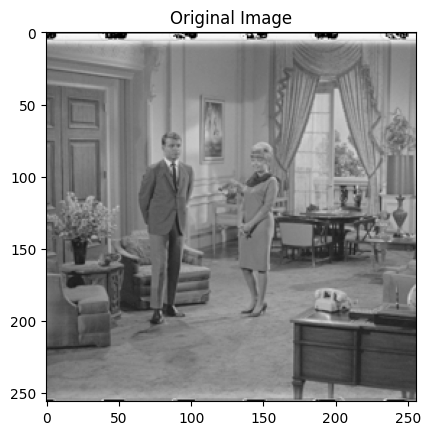

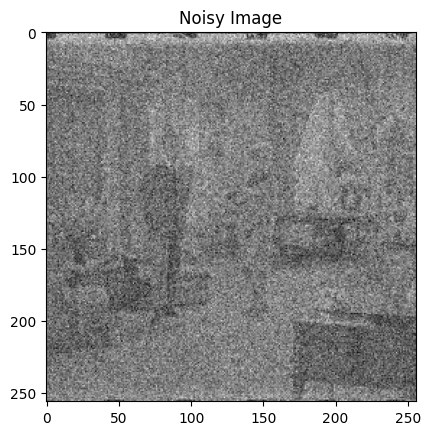

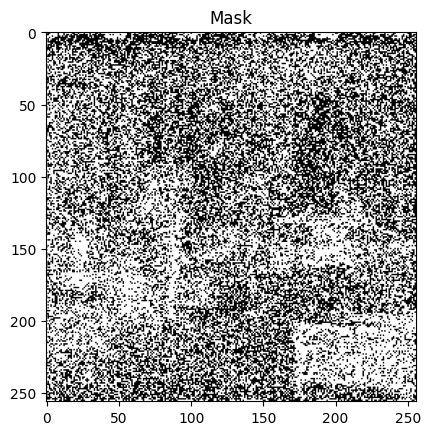

In [10]:
#noisy_im
#im
import cv2
difference = cv2.absdiff(im, noisy_im)
threshold = 0.15

# Create a binary mask indicating noisy pixels
noisy_pixel_mask = difference > threshold

_, ax_image = plt.subplots()
ax_image.imshow(im, cmap='gray')
ax_image.set_title('Original Image')

_, ax_noisy = plt.subplots()
ax_noisy.imshow(noisy_im, cmap='gray')
ax_noisy.set_title('Noisy Image')

_, ax_noisy_mask = plt.subplots()
ax_noisy_mask.imshow(noisy_pixel_mask, cmap='gray')
ax_noisy_mask.set_title('Mask')

plt.show()

In [11]:
difference

array([[0.42373961, 0.41359599, 0.4908919 , ..., 0.3174758 , 0.45252331,
        0.45295221],
       [0.22689232, 0.09639545, 0.12814119, ..., 0.34141326, 0.28872958,
        0.35281594],
       [0.10165058, 0.05767202, 0.27037742, ..., 0.18974868, 0.05599146,
        0.0398295 ],
       ...,
       [0.04818135, 0.01502054, 0.05919227, ..., 0.1910323 , 0.04959105,
        0.02898466],
       [0.13555472, 0.13359209, 0.09382782, ..., 0.26961145, 0.21686899,
        0.05482485],
       [0.37093901, 0.41926767, 0.56222066, ..., 0.09068925, 0.10712797,
        0.1828832 ]])

In [12]:
inverted_mask = ~noisy_pixel_mask
noisy_pixel_coordinates = np.where(inverted_mask)

In [13]:
true_coordinates = np.where(inverted_mask)
coords = []
# Print the coordinates
for row, col in zip(*true_coordinates):
    print(f"Row: {row}, Column: {col}")
    coords.append((row,col))

Row: 0, Column: 20
Row: 0, Column: 33
Row: 0, Column: 42
Row: 0, Column: 48
Row: 0, Column: 63
Row: 0, Column: 66
Row: 0, Column: 183
Row: 0, Column: 185
Row: 0, Column: 205
Row: 0, Column: 237
Row: 0, Column: 245
Row: 1, Column: 1
Row: 1, Column: 2
Row: 1, Column: 8
Row: 1, Column: 12
Row: 1, Column: 18
Row: 1, Column: 19
Row: 1, Column: 22
Row: 1, Column: 26
Row: 1, Column: 30
Row: 1, Column: 34
Row: 1, Column: 35
Row: 1, Column: 37
Row: 1, Column: 56
Row: 1, Column: 57
Row: 1, Column: 58
Row: 1, Column: 61
Row: 1, Column: 64
Row: 1, Column: 65
Row: 1, Column: 67
Row: 1, Column: 68
Row: 1, Column: 69
Row: 1, Column: 70
Row: 1, Column: 72
Row: 1, Column: 75
Row: 1, Column: 77
Row: 1, Column: 80
Row: 1, Column: 82
Row: 1, Column: 85
Row: 1, Column: 86
Row: 1, Column: 87
Row: 1, Column: 88
Row: 1, Column: 89
Row: 1, Column: 90
Row: 1, Column: 95
Row: 1, Column: 100
Row: 1, Column: 110
Row: 1, Column: 111
Row: 1, Column: 112
Row: 1, Column: 113
Row: 1, Column: 115
Row: 1, Column: 117
Row

In [14]:
print(coords)

[(0, 20), (0, 33), (0, 42), (0, 48), (0, 63), (0, 66), (0, 183), (0, 185), (0, 205), (0, 237), (0, 245), (1, 1), (1, 2), (1, 8), (1, 12), (1, 18), (1, 19), (1, 22), (1, 26), (1, 30), (1, 34), (1, 35), (1, 37), (1, 56), (1, 57), (1, 58), (1, 61), (1, 64), (1, 65), (1, 67), (1, 68), (1, 69), (1, 70), (1, 72), (1, 75), (1, 77), (1, 80), (1, 82), (1, 85), (1, 86), (1, 87), (1, 88), (1, 89), (1, 90), (1, 95), (1, 100), (1, 110), (1, 111), (1, 112), (1, 113), (1, 115), (1, 117), (1, 121), (1, 122), (1, 124), (1, 126), (1, 127), (1, 129), (1, 130), (1, 131), (1, 135), (1, 136), (1, 137), (1, 144), (1, 145), (1, 148), (1, 154), (1, 156), (1, 157), (1, 166), (1, 172), (1, 174), (1, 175), (1, 178), (1, 184), (1, 185), (1, 200), (1, 201), (1, 204), (1, 205), (1, 206), (1, 208), (1, 210), (1, 211), (1, 212), (1, 214), (1, 215), (1, 216), (1, 217), (1, 221), (1, 226), (1, 227), (1, 234), (1, 240), (1, 241), (1, 250), (1, 251), (1, 252), (2, 0), (2, 1), (2, 8), (2, 12), (2, 14), (2, 15), (2, 17), (2

In [15]:
updated_coords = coords

In [16]:
# n        = 30
# rank     = 8
# m        = int(0.4 * n**(1.25) * rank * np.log(n))
# M        = np.dot(np.random.randn(n, rank), np.random.randn(n, rank).T)
# X, omega = mask_out_matrix(im, coords) # strictly speaking, not necessary

# print("Nuclear Norm of original matrix M: {:6.4f}".format(np.linalg.norm(M, "nuc")))
# print('Average entry-wise difference before recovery:', np.mean(np.abs(M - X)))

recovered = complete_matrix(noisy_im, updated_coords)


# print('Average entry-wise difference after recovery:', np.mean(np.abs(M - recovered)))
# print("Nuclear Norm of recoverd matrix: {:6.4f}".format(np.linalg.norm(recovered, "nuc")))

In [ ]:
recovered

array([[0.13954529, 0.10288157, 0.1049307 , ..., 0.09340075, 0.0938295 ,
        0.10384587],
       [0.3314385 , 0.25988504, 0.13939133, ..., 0.52737254, 0.52062153,
        0.413834  ],
       [0.26807657, 0.12989422, 0.5611772 , ..., 0.84983972, 0.94645751,
        0.95950459],
       ...,
       [0.50255133, 0.54567397, 0.59318019, ..., 0.48240379, 0.41956217,
        0.49435295],
       [0.74565747, 0.74802232, 0.71197254, ..., 0.67434653, 0.59439569,
        0.45933025],
       [0.33037758, 0.37384871, 0.35681063, ..., 0.63440369, 0.64372497,
        0.70093078]])

Text(0.5, 1.0, 'Exact Matrix Image, PSNR=19.68')

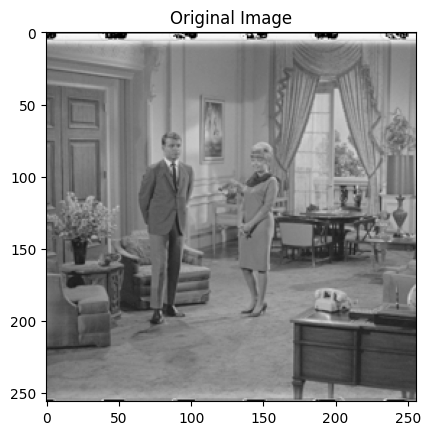

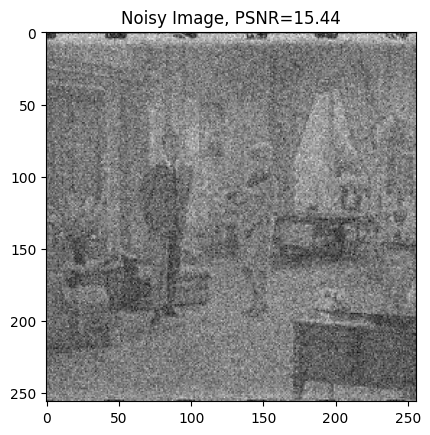

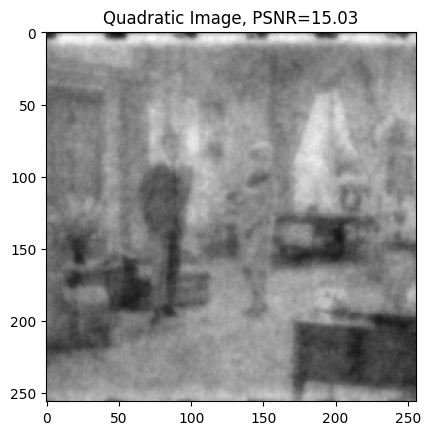

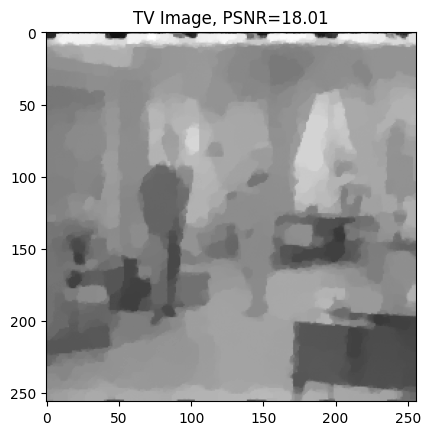

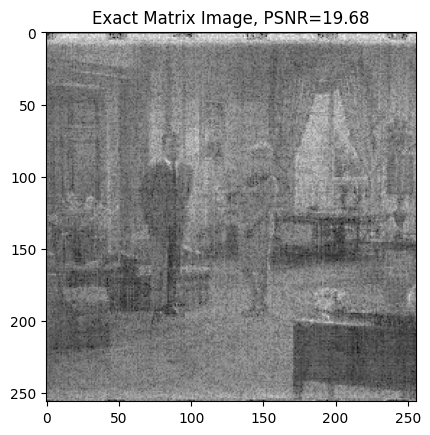

In [ ]:
_, ax_image = plt.subplots()
ax_image.imshow(im, cmap='gray')
ax_image.set_title('Original Image')

fig_noisy, ax_noisy = plt.subplots()
ax_noisy.imshow(noisy_im, cmap='gray')
ax_noisy.set_title(f'Noisy Image, PSNR={round(PSNR(original_im=im, cleaned_im=noisy_im), 2)}')

fig_quad, ax_quad = plt.subplots()
ax_quad.imshow(quad_im, cmap='gray')
ax_quad.set_title(f'Quadratic Image, PSNR={round(PSNR(original_im=im, cleaned_im=quad_im), 2)}')

fig_tv, ax_tv = plt.subplots()
ax_tv.imshow(TV_im, cmap='gray')
ax_tv.set_title(f'TV Image, PSNR={round(PSNR(original_im=im, cleaned_im=TV_im), 2)}')

_, ax_rec_image = plt.subplots()
ax_rec_image.imshow(recovered, cmap='gray')
ax_rec_image.set_title(f'Exact Matrix Image, PSNR={round(PSNR(original_im=im, cleaned_im=recovered), 2)}')


In [ ]:
PSNR(original_im=im, cleaned_im=im)

100